# 3D Plot of Autocorrelation

Before viewing centroids, I'd like to view them as 3D contour plots

In [1]:
# Import Modules
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.fftpack import fft2,ifft2,fftshift
from speckle_fns import fits_import, circ_filter1
from speckle_fns import deconv0,deconv1, postprocess
from speckle_fns import filter_lpf, filter_hpf, filter_interference
import cv2

%matplotlib inline

Filename: /home/niels/Desktop/KP330_PSD.fits
No.    Name         Type      Cards   Dimensions   Format
0    PRIMARY     PrimaryHDU       6   (512, 512)   float64   

Filename: /home/niels/Desktop/KP331_PSD.fits
No.    Name         Type      Cards   Dimensions   Format
0    PRIMARY     PrimaryHDU       6   (512, 512)   float64   



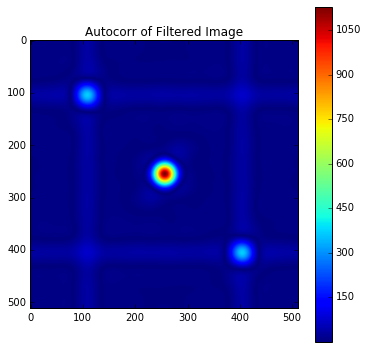

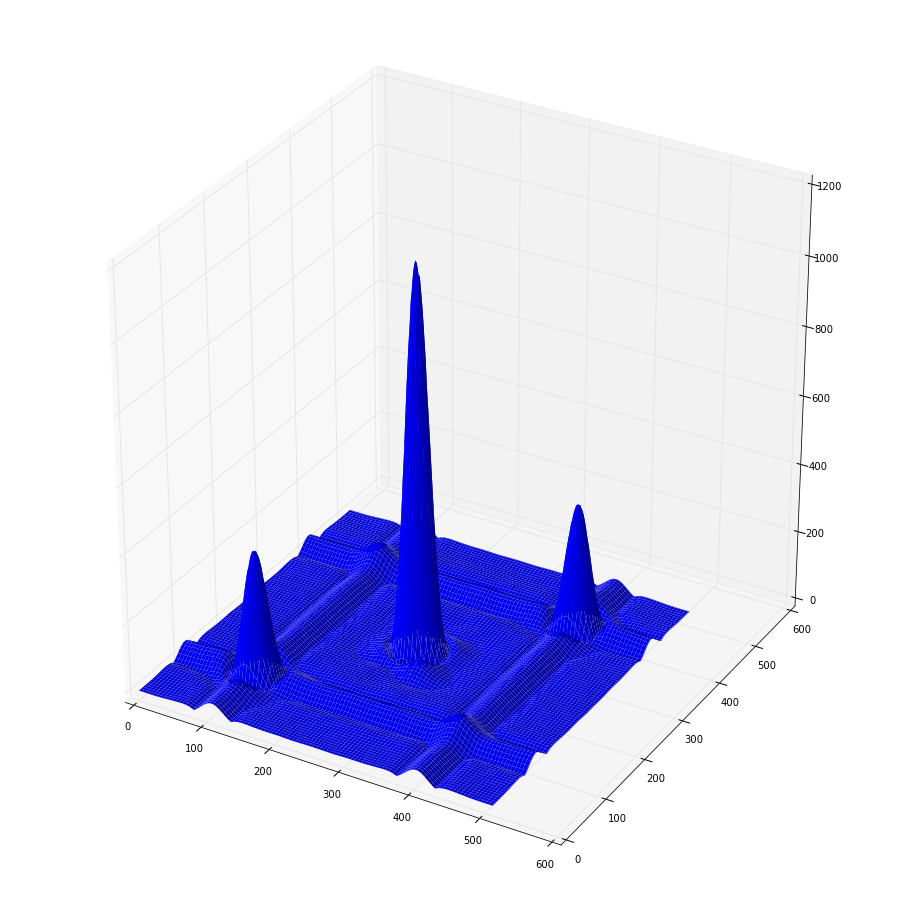

In [2]:
# Generating Autocorrelogram

# Filenames
filePathDouble = "/home/niels/Desktop/KP330_PSD.fits"
filePathSingle = "/home/niels/Desktop/KP331_PSD.fits"
# Import FITS file data
fitsDoubleStar = fits_import(filePathDouble)
fitsSingleStar = fits_import(filePathSingle)
# Convert FITS Data to Floats
psdDoubleStar = fitsDoubleStar.astype(float)
psdSingleStar = fitsSingleStar.astype(float)

# Perform Deconvolution
constant = 1E-15
imgF = fftshift(deconv1(psdDoubleStar, psdSingleStar, constant))

# Filter PSD:
imgF_filtered = filter_interference(imgF)
imgF_filtered = filter_lpf(imgF_filtered, 5)
imgF_filtered = filter_hpf(imgF_filtered, 6, 0.8)

# Postprocess
img_autocorr = postprocess(imgF_filtered)

# Plot Image
plt.figure(figsize = (6,6))
plt.imshow(img_autocorr)
plt.title("Autocorr of Filtered Image")
plt.colorbar()

# Create variables for surface plot
x = np.arange(512)
y = np.arange(512)
x,y = np.meshgrid(x,y)
z = img_autocorr

# Plot surface plot 
fig = plt.figure(figsize=(16,16))
ax = fig.gca(projection='3d')
surf = ax.plot_surface(x,y,z,rstride=5,cstride=5, linewidth=0)

1127.40701952


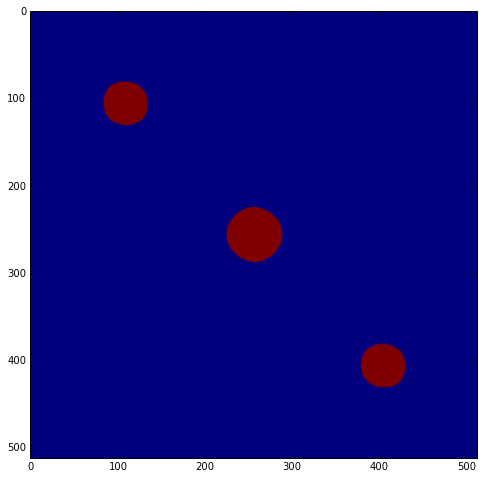

In [3]:
# Using thresholding to try to find the peaks
# Start with the max value of the image (so I'd remove everything), and work my way down
#  until I have 3 well defined regions

max_pixel = np.max(z)
print(max_pixel)

threshold = 75

threshold_img = np.zeros(np.shape(z))

for row in range(np.shape(z)[0]):
    for column in range(np.shape(z)[0]):
        threshold_img[row,column] = (z[row,column]>threshold)

fig = plt.figure(figsize=(8,8))
plt.imshow(threshold_img)



Number of Contours:  3


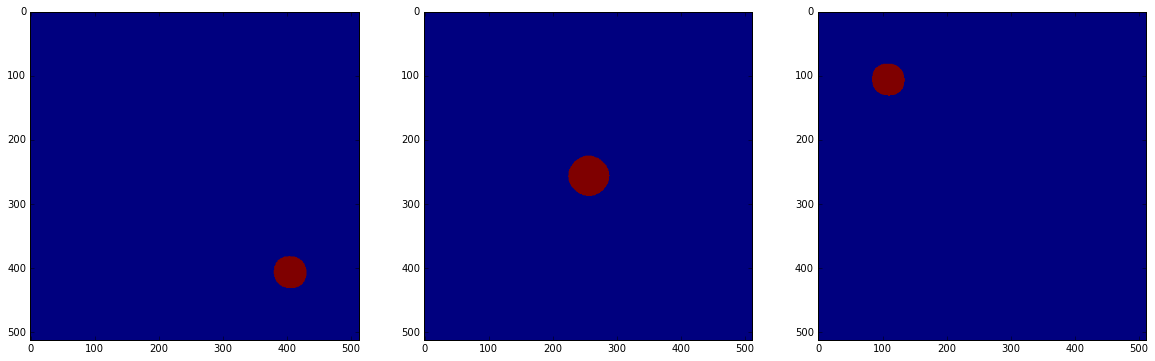

In [4]:
# Attempting to use openCV to find the 3 countours of thresholded 
threshold_img_scale = (np.multiply(255,threshold_img.astype(np.uint8)))

# Find Contours
im2,contours,hierarchy = cv2.findContours(threshold_img_scale,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)

# Display Contours
plt.figure(figsize=(20,7))
for i in np.arange(3):
    plt.subplot(1,3,i+1)
    
    # Draw contours on image
    mask = np.zeros((512,512))
    cv2.drawContours(mask,contours,i,(255,255,255),-1)
    plt.imshow(mask)

print("Number of Contours: ", len(contours))


75.0


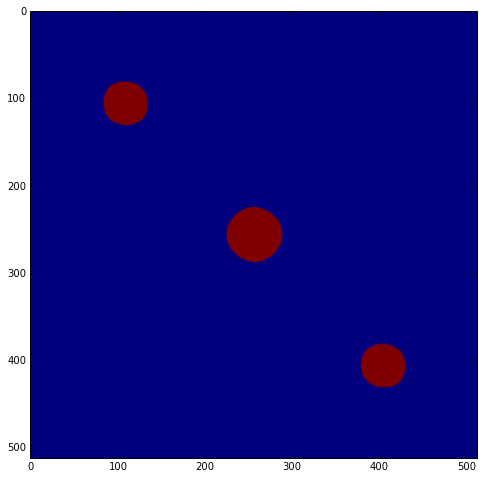

In [5]:
# Want to find the lowest threshold that we only see the 3 main lobes
autocorr = np.array(z)

# Start thresh at max value of autocorr (assuming that is from central peak)
threshold = np.floor(autocorr.max())

# Assume we start with 1 contour visible 
num_contours = 1

# Step down in steps of 5 until we have gone too far
while (num_contours < 4):
    # Decrement the threshold
    threshold = threshold - 5
    
    # Calculate indices in image above threshold
    above_thresh_i = autocorr > threshold
    
    # Create thresholded image
    autocorr_thresh = np.zeros(np.shape(autocorr))
    autocorr_thresh[above_thresh_i] = 255
    autocorr_thresh = autocorr_thresh.astype(np.uint8)
    
    # Find contours of threshold image
    im,contours,hierarchy = cv2.findContours(autocorr_thresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    num_contours = len(contours)

# Step back up in threshold until we are back to 3 contours
while (num_contours > 3):
    # Decrement the threshold
    threshold = threshold + 1
    
    # Calculate indices in image above threshold
    above_thresh_i = autocorr > threshold
    
    # Create thresholded image
    autocorr_thresh = np.zeros(np.shape(autocorr))
    autocorr_thresh[above_thresh_i] = 255
    autocorr_thresh = autocorr_thresh.astype(np.uint8)
    
    # Find contours of threshold image
    im,contours,hierarchy = cv2.findContours(autocorr_thresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    num_contours = len(contours)    


# Calculate indices in image above threshold
above_thresh_i = autocorr > threshold
    
# Create thresholded image
autocorr_thresh = np.zeros(np.shape(autocorr))
autocorr_thresh[above_thresh_i] = 255
autocorr_thresh = autocorr_thresh.astype(np.uint8)

# Display results
print(threshold)
plt.figure(figsize=(8,8))
plt.imshow(autocorr_thresh)



[[ 405.  403.]
 [ 256.  256.]
 [ 106.  108.]]


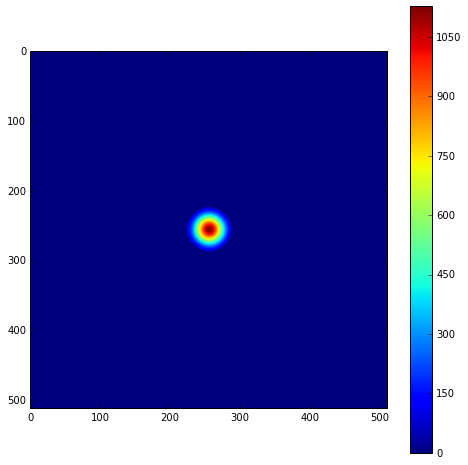

In [6]:
## Now that we have the contours, we want to find their centroids for sorting purposes
centroid = np.zeros((3,2))

for i in np.arange(3):
    # Calculating Image Moment/Raw Moment of contour
    M = cv2.moments(contours[i])
    
    # Calculate centroid X and Y components 
    cx = int(M['m10']/M['m00'])
    cy = int(M['m01']/M['m00'])
    
    centroid[i] = (cy, cx)
    
print(centroid)

## Find the central contour
# Center pixel indices
center = np.divide(np.shape(autocorr),2)
center_distance = np.zeros(3)

# Calculate distance from each centroid to center of image
for i in np.arange(3):
    center_distance[i] = np.linalg.norm(centroid[i] - center)

# Get index of central contour as contour with min distance to center
i = np.where(center_distance == center_distance.min())
i_center = i[0]

# Show central contour
mask_center = np.zeros(np.shape(autocorr))
cv2.drawContours(mask_center,contours,i_center,(1,1,1),-1)

plt.figure(figsize=(8,8))
plt.imshow(np.multiply(mask_center,autocorr))
plt.colorbar()

## 15-12-18

Now that masks are find-able, we'd like to calculate the intensity weighted centroid of the side lobes

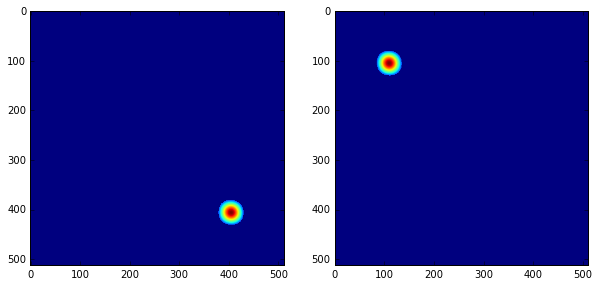

In [63]:
## Finding indices of side lobes
# Possible indices of side lobes
i_side_lobes = [0,1,2]
# Remove the center lobe index
i_side_lobes.remove(i_center)

# Make empty mask images
mask_side = np.zeros((2,np.shape(autocorr)[0],np.shape(autocorr)[1]))

# Create masks for both side lobes
for i in np.arange(2):
    cv2.drawContours(mask_side[i],contours,i_side_lobes[i],(1,1,1),-1)
    lobe_side = 

# View both side lobes
plt.figure(figsize=(10,5))
for i in np.arange(2):
    plt.subplot(1,2,i+1)
    plt.imshow(np.multiply(autocorr,mask_side[i]))


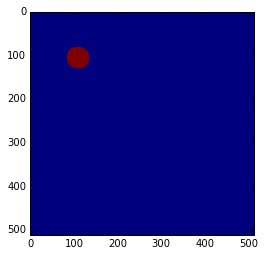

In [59]:
plt.imshow(mask_side[1])